# Is it Fake or Real News?

## Brief Description of Dataset
#### The source of our dataset is  Kaggle.  Dataset is composed of  2 files: ‘True’ and ‘Fake’. <br/>The data in ‘fake’ file consists 17,903 unique records for articles published from March 2015- December 2017. <br/> The data in ‘true’ file consists of 20,826 unique records for articles published from January 2016- December 2017 . <br/>Number of Columns = 4 in each: <br/><br/>1) Title: Title of Article <br/>2) Text: Text of Article <br/>3) Subject: Subject of Article <br/>4) Date: Date at which the article was posted.


## Loading the Necessary Libraries

In [1]:
import pandas as pd        
import numpy as np
#for text pre-processing
import nltk
from nltk.corpus import stopwords
import re,string,unicodedata
import seaborn as sea
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud,STOPWORDS #WordCloud and Stopwords
from bs4 import BeautifulSoup #HTML parser
from sklearn.model_selection import train_test_split
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Random Forest
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, SVC
from nltk.classify.scikitlearn import SklearnClassifier

## Importing the Dataset

In [2]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

## Data Visualization and Preprocessing

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17
3,Trump Is So Obsessed He Even Has Obamaâ€™s Na...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17


In [5]:
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [6]:
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])
true["publisher"] = publisher
true["text"] = tmp_text

In [7]:
true

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,NATO allies on Tuesday welcomed President Don...,worldnews,"August 22, 2017",BRUSSELS (Reuters)
21413,LexisNexis withdrew two products from Chinese ...,"LexisNexis, a provider of legal, regulatory a...",worldnews,"August 22, 2017",LONDON (Reuters)
21414,Minsk cultural hub becomes haven from authorities,In the shadow of disused Soviet-era factories...,worldnews,"August 22, 2017",MINSK (Reuters)
21415,Vatican upbeat on possibility of Pope Francis ...,Vatican Secretary of State Cardinal Pietro Pa...,worldnews,"August 22, 2017",MOSCOW (Reuters)


In [8]:
# Creating Category column in both the datasets. To categorize the true and fake news
true['category'] = 1
fake['category'] = 0

In [9]:
concat = pd.concat([true,fake]) # Merging two datasets

In [10]:
concat.category.value_counts()

0    23471
1    21417
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

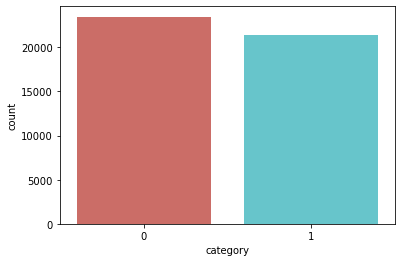

In [11]:

sea.countplot(x = concat.category,palette="hls", data=concat )


### We can see that the dataset is relatively balanced with 23471 Fake News and 21417 True News. Since the data is balanced, we won’t be applying data-balancing techniques like SMOTE while building the model

In [12]:
concat.head()

,title,text,subject,date,publisher,category
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


In [13]:
concat.isna().sum() #Checking for missing values

title            0
text             0
subject          0
date             0
publisher    23471
category         0
dtype: int64

In [14]:
#Dropping publisher column as it is not required
concat.drop(['publisher'], axis = 1 , inplace= True)

In [15]:
concat.dtypes #Checking the DataTypes

title       object
text        object
subject     object
date        object
category     int64
dtype: object

In [16]:
concat.count() #Counting the number of entries

title       44888
text        44888
subject     44888
date        44888
category    44888
dtype: int64

In [17]:
concat.subject.value_counts() 

politicsNews       11272
worldnews          10145
News                9050
politics            6836
left-news           4457
Government News     1568
US_News              783
Middle-east          777
Name: subject, dtype: int64

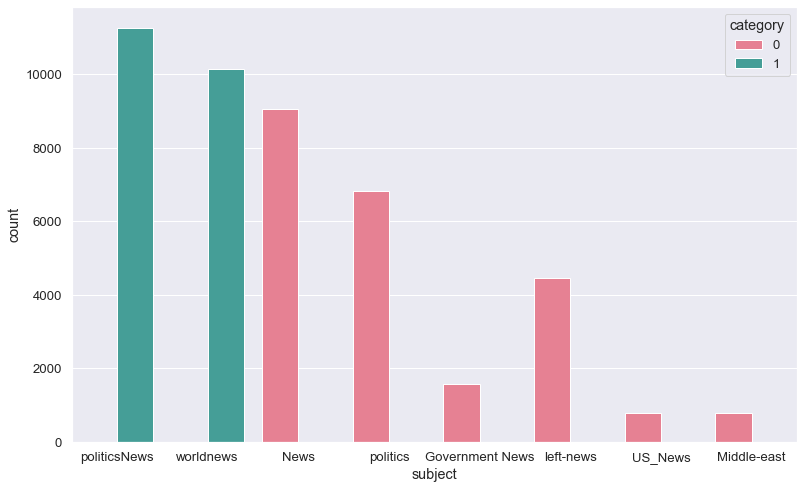

In [18]:
plt.figure(figsize = (13,8))

sea.set(font_scale = 1.2)
chart = sea.countplot(x = "subject",  hue = "category" ,palette="husl", data = concat)

### Since the topics in the Subject column are different for both Fake and True News Categories, Hence we have to exclude it from the final text column.

### Further the Date column is also not needed as we are not dealing with the time series modeling. 

In [19]:
concat.drop(['subject', 'date'], axis=1, inplace= True)

In [20]:
concat.head()

,title,text,category
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,1


### For text analysis we will be merging data in title and text column into one column.

In [21]:
concat["merged_text"] = concat["title"] + " " + concat["text"]
concat.drop(['title','text'], axis = 1 , inplace= True)

In [22]:
concat.head()

,category,merged_text
0,1,"As U.S. budget fight looms, Republicans flip t..."
1,1,U.S. military to accept transgender recruits o...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,FBI Russia probe helped by Australian diplomat...
4,1,Trump wants Postal Service to charge 'much mor...


In [23]:
concat.isna().sum() #Checking for null values

category       0
merged_text    0
dtype: int64

## Cleaning the Text Data

### Text data contains a lot of noise either in the form of symbols or in the form of URLs, punctuations and stopwords. Therefore, it becomes necessary to clean the text, not just for making it more understandable but also for getting better insights.
### From the "merged_text" we want to parse human-readable text, For that we will use beautifulsoup library.

In [24]:
def strip_html(text): #This function is removing all the HTML tags
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
concat['merged_text']=concat['merged_text'].apply(strip_html)

### Removing the square brackets

In [25]:
def remove_between_square_brackets(text): 
    return re.sub('\[[^]]*\]', '', text)
concat['merged_text']=concat['merged_text'].apply(remove_between_square_brackets)

### Removing URLs

In [26]:
def remove_url(text):
    return re.sub(r'http\S+', '', text)
concat['merged_text']=concat['merged_text'].apply(remove_url)

### Removing the stop words

In [27]:
nltk.download('stopwords') #Downloading the stopwords
stop = set(stopwords.words('english')) #saving the stop words in to the variable stop
punctuation = list(string.punctuation) #Getting punctuations through import string lib
stop.update(punctuation) # merging stop list and punctuation list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
concat['merged_text']=concat['merged_text'].apply(remove_stopwords)


### Removing the numeric values/digits

In [29]:
concat['merged_text'] = concat['merged_text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [30]:
concat.category.value_counts()

0    23471
1    21417
Name: category, dtype: int64

### Removing duplicates

In [31]:
# Checking if any duplicate records are present
duplicate= concat[concat.duplicated()] 
duplicate


,category,merged_text
445,1,Senate tax bill stalls deficit-focused 'trigge...
778,1,Trump warns 'rogue regime' North Korea grave d...
892,1,"Republicans unveil tax cut bill, hard work awa..."
896,1,Trump taps Fed centrist Powell lead U.S. centr...
974,1,"Two ex-Trump aides charged Russia probe, third..."
...,...,...
23466,0,McPain: John McCain Furious Iran Treated US Sa...
23467,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23468,0,Sunnistan: US Allied â€˜Safe Zoneâ€™ Plan Take...
23469,0,Blow $ Million: Al Jazeera America Finally Cal...


In [32]:
# Removing duplicate records
concat.drop_duplicates(inplace=True)

In [33]:

# Again check if any duplicate records are left
duplicate= concat[concat.duplicated()] 
duplicate

,category,merged_text


<AxesSubplot:xlabel='category', ylabel='count'>

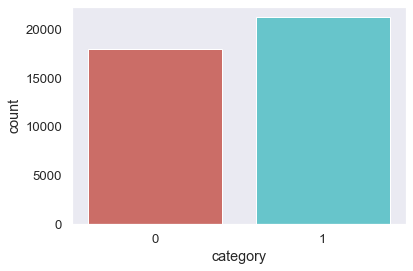

In [55]:
sea.countplot(x = concat.category,palette="hls", data=concat )

In [56]:
concat.category.value_counts()

1    21195
0    17899
Name: category, dtype: int64

## Exploratory Data Analysis

### Wordcloud for True Text

### Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

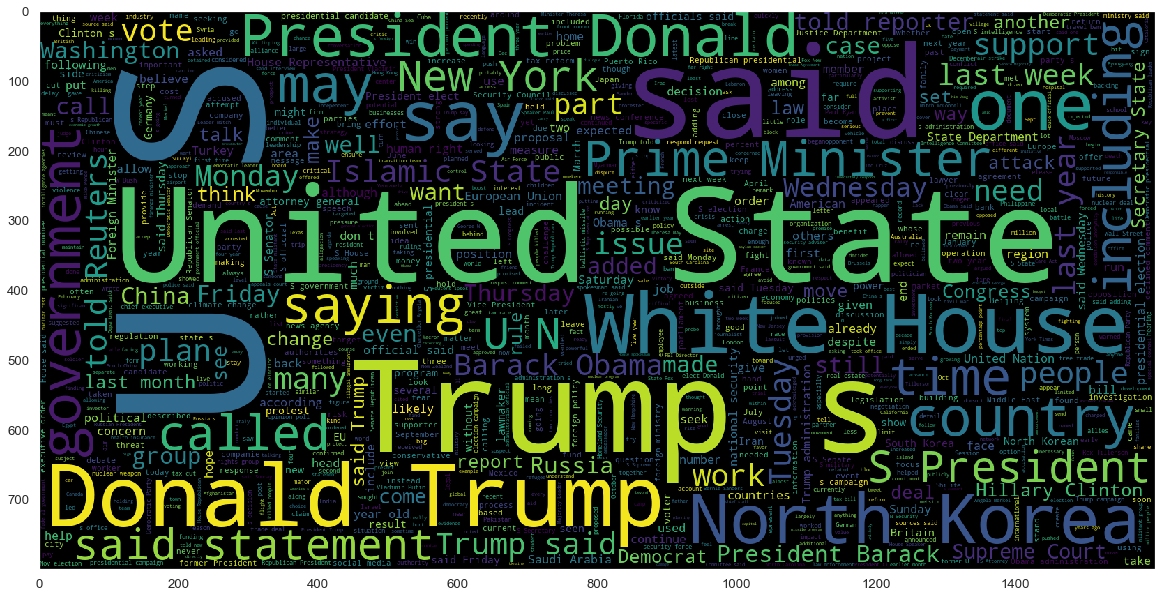

In [34]:
plt.figure(figsize = (20,20)) # Text that is not Fake
plt.rcParams["axes.grid"] = False
wc = WordCloud(max_words = 1000 , width = 1600 , background_color="black", height = 800 , stopwords = STOPWORDS).generate(" ".join(concat[concat.category == 1].merged_text))
plt.imshow(wc , interpolation = 'none')
plt.show()

### Wordcloud for Fake Text

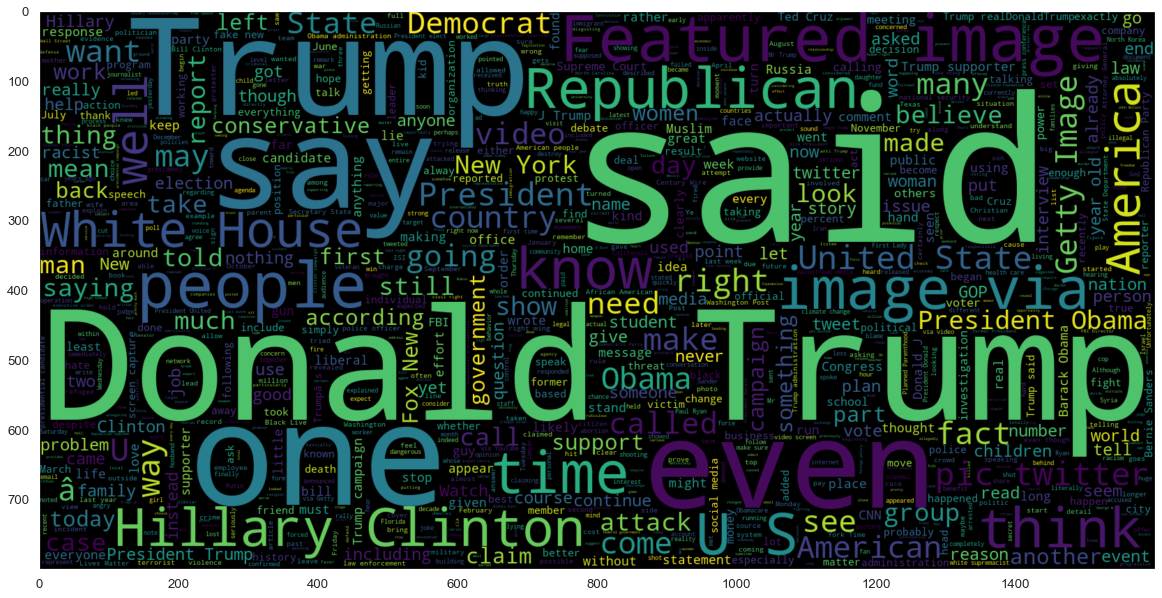

In [35]:
plt.figure(figsize = (20,20)) # Text that is not Fake
plt.rcParams["axes.grid"] = False
wc = WordCloud(max_words = 1000 , width = 1600 , background_color="black", height = 800 , stopwords = STOPWORDS).generate(" ".join(concat[concat.category == 0].merged_text))
plt.imshow(wc , interpolation = 'bilinear')

### Plotting Number of Characters in Texts

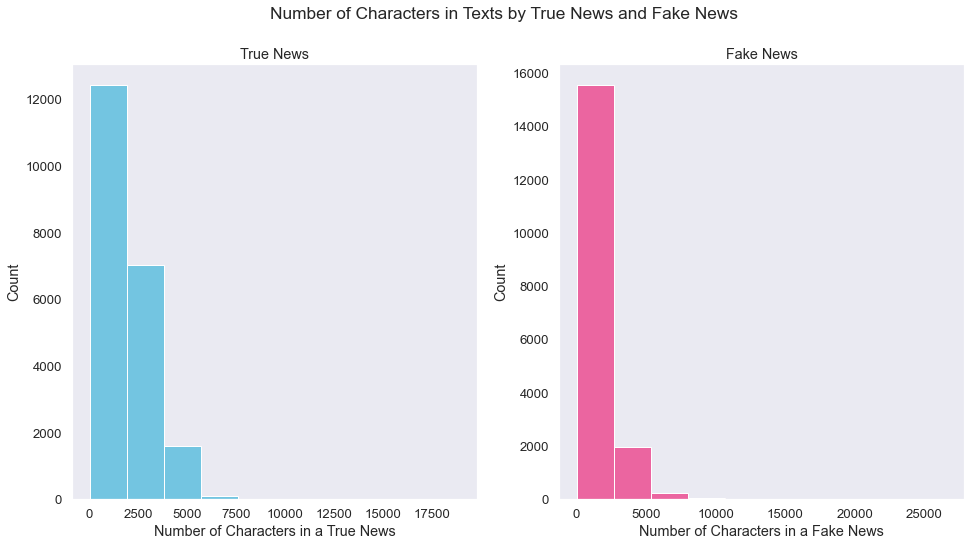

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8)) #
text_len=concat[concat['category']==1]['merged_text'].str.len() 
ax1.hist(text_len,color='#73C5E1')
ax1.set_title('True News')
ax1.set(ylabel= 'Count', xlabel= 'Number of Characters in a True News')
text_len=concat[concat['category']==0]['merged_text'].str.len()
ax2.hist(text_len,color='#EB65A0')
ax2.set_title('Fake News')
ax2.set(ylabel='Count', xlabel='Number of Characters in a Fake News')
fig.suptitle('Number of Characters in Texts by True News and Fake News')
plt.show()

### In the above distribution we can see that there are 2500 characters in text is the most common in True News category while around 5000 characters in text are most common in Fake News category.

### Plotting Number of words in each text

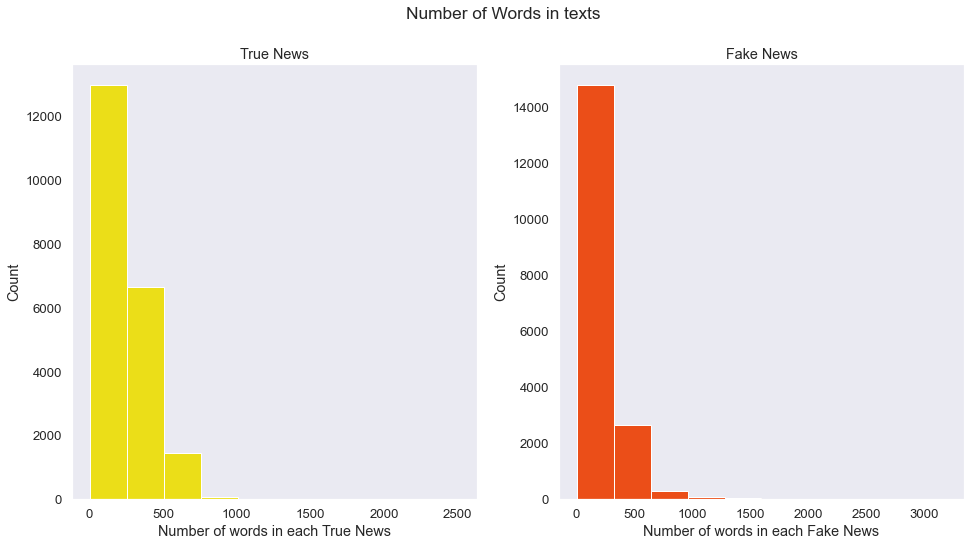

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
text_len=concat[concat['category']==1]['merged_text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='#EBDE18')
ax1.set_title('True News')
ax1.set(ylabel= 'Count', xlabel= 'Number of words in each True News')
text_len=concat[concat['category']==0]['merged_text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='#EB4E18')
ax2.set_title('Fake News')
ax2.set(ylabel='Count', xlabel='Number of words in each Fake News')
fig.suptitle('Number of Words in texts')
plt.show()

### In the above distribution we can see that there are more words in a True News when compared to the Fake News.

### Plotting Average Word Length in a Text

6.685114544361886
6.568726197324828


Text(0.5, 0.98, 'Average word length in each text by True News and Fake News')

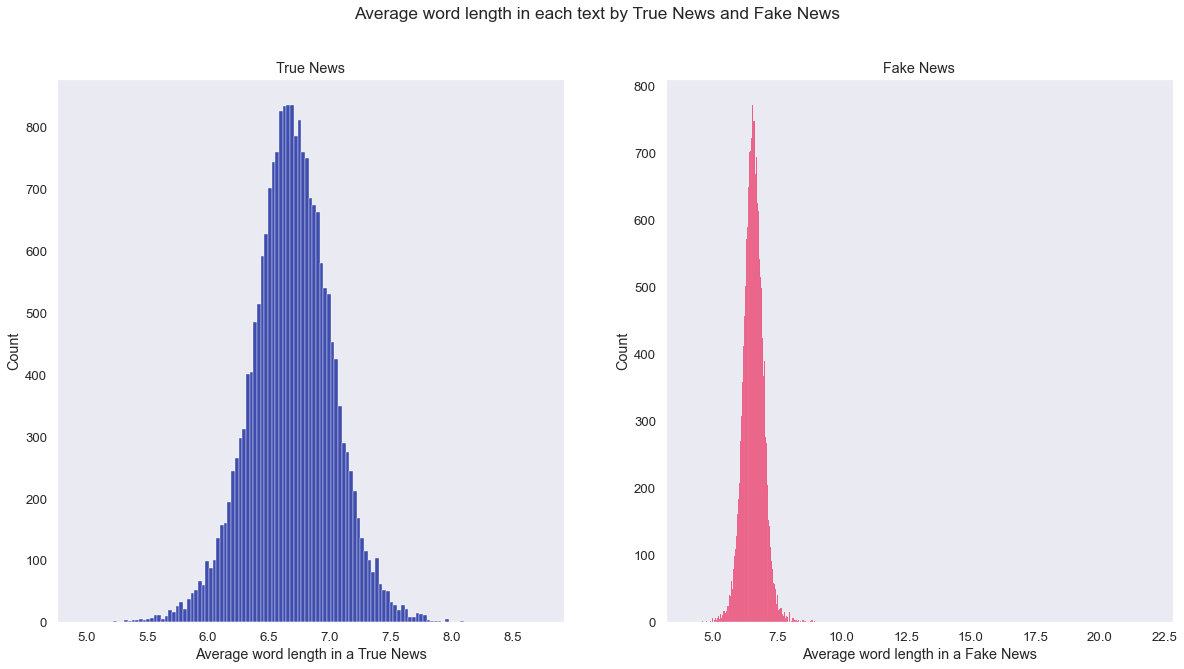

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=concat[concat['category']==1]['merged_text'].str.split().apply(lambda x : [len(i) for i in x])
sea.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#041898')
print(word.map(lambda x: np.mean(x)).mean())
ax1.set_title('True News')
ax1.set(ylabel= 'Count', xlabel= 'Average word length in a True News')
word=concat[concat['category']==0]['merged_text'].str.split().apply(lambda x : [len(i) for i in x])
sea.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#E71B52')
print(word.map(lambda x: np.mean(x)).mean())
ax2.set_title('Fake News')
ax2.set(ylabel='Count', xlabel='Average word length in a Fake News')
fig.suptitle('Average word length in each text by True News and Fake News')

### The average word length in a text for the true news and fake news is same.

### Listing and Counting

In [39]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(concat.merged_text)
corpus[:5]

['U.S.', 'budget', 'fight', 'looms,', 'Republicans']

In [40]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 101647,
 'said': 86442,
 'would': 49053,
 ',': 47048,
 'U.S.': 46931,
 'people': 28669,
 'President': 28483,
 'also': 26304,
 'Donald': 25259,
 'one': 24820}

### N-Gram ranking Visualisation

### In n-gram ranking, we simply rank the n-grams according to how many times they appear in a body of text — be it a book, a collection of tweets, or reviews left by customers of your company.
### Reference: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Uni-Gram

<AxesSubplot:>

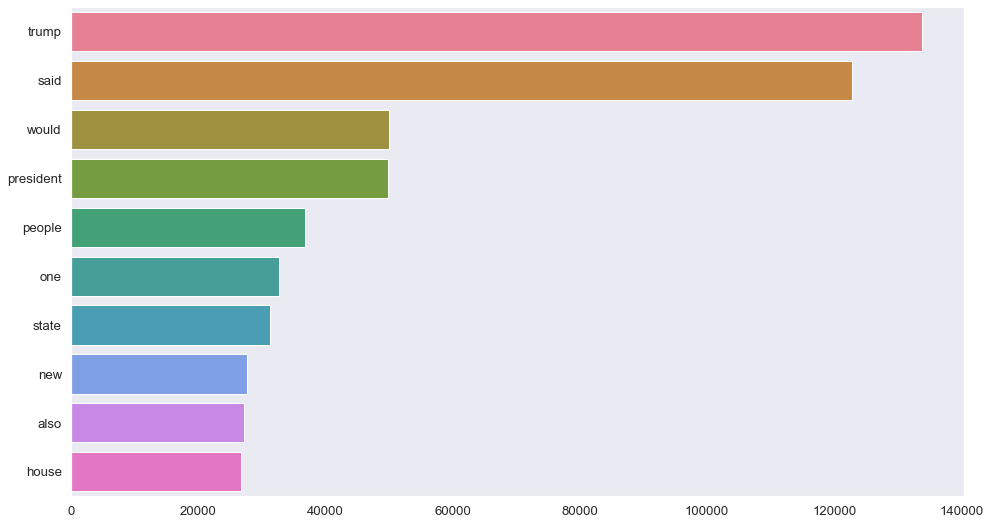

In [42]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(concat.merged_text,10,1)
most_common_uni = dict(most_common_uni)
sea.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()),palette="husl")

### Bi-Gram

<AxesSubplot:>

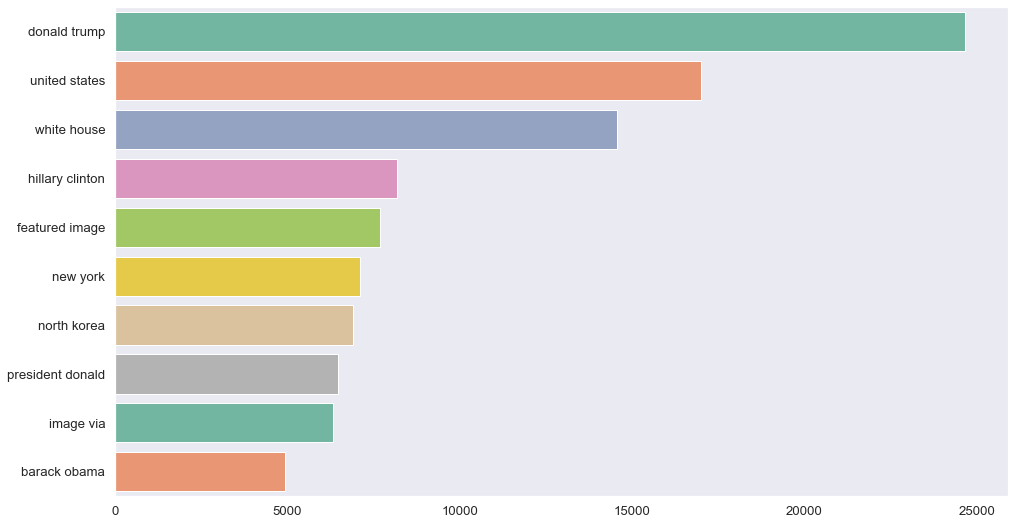

In [43]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(concat.merged_text,10,2)
most_common_bi = dict(most_common_bi)
sea.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()),palette="Set2")

### Tri-Gram

<AxesSubplot:>

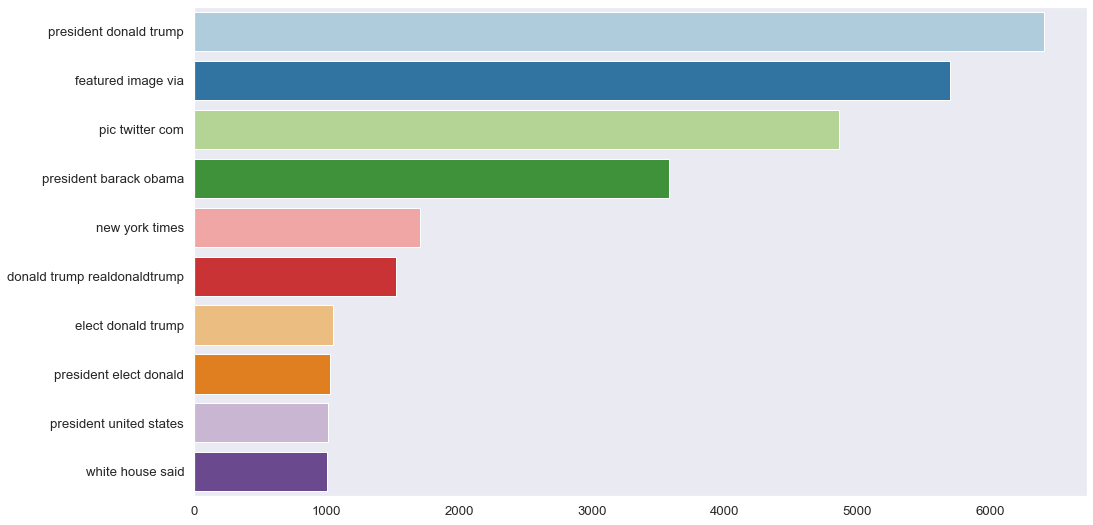

In [44]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(concat.merged_text,10,3)
most_common_tri = dict(most_common_tri)
sea.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()),palette="Paired")

## Splitting the Dataset

In [45]:
X_train, X_test, y_train, y_test = train_test_split(concat["merged_text"],concat["category"],test_size=0.2,shuffle=True)

## Training the Model

### The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding. We have used bag-of-words for converting text data to numerical data.
### In bag-of-words we have used Term Frequency-Inverse Document Frequencies (tf-Idf). to convert text data into numerical data/vector.
### In Term Frequency-Inverse Document Frequencies (tf-Idf), the value of a word increases proportionally to count in the document, but it is inversely proportional to the frequency of the word in the corpus

In [46]:

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)



### Logistic Regression

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3604
           1       0.99      0.99      0.99      4215

    accuracy                           0.99      7819
   macro avg       0.99      0.99      0.99      7819
weighted avg       0.99      0.99      0.99      7819

Confusion Matrix:
[[3563   41]
 [  37 4178]]
Accuracy(in percent):  99.00242997825809
AUC: 0.9993756772164315


Text(64.5, 0.5, 'Actual')

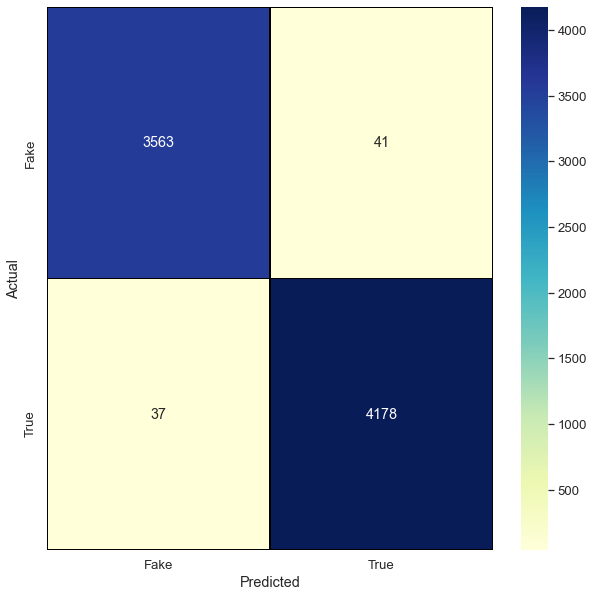

In [47]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print('Classification Report')
print(classification_report(y_test,y_predict))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_predict))
print('Accuracy(in percent): ',accuracy_score(y_test, y_predict)*100 )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

cm = confusion_matrix(y_test, y_predict)
cm = pd.DataFrame(cm , index = ['Fake','True'] , columns = ['Fake','True'])
plt.figure(figsize = (10,10))
sea.heatmap(cm,cmap= "YlGnBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


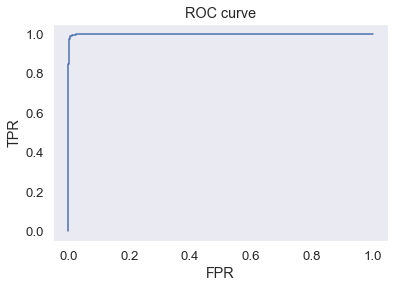

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


### Naive Bayes

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3604
           1       0.93      0.96      0.94      4215

    accuracy                           0.94      7819
   macro avg       0.94      0.94      0.94      7819
weighted avg       0.94      0.94      0.94      7819

Confusion Matrix:
[[3288  316]
 [ 171 4044]]
Accuracy(in percent):  93.77158204373961
AUC: 0.9834409638427316


Text(64.5, 0.5, 'Actual')

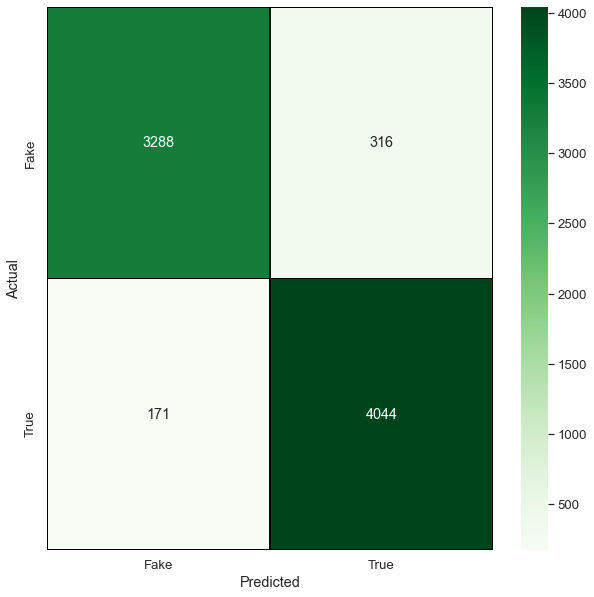

In [49]:

#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print('Classification Report')
print(classification_report(y_test,y_predict))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_predict))
print('Accuracy(in percent): ',accuracy_score(y_test, y_predict)*100 )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

Nai = confusion_matrix(y_test, y_predict)
Nai = pd.DataFrame(Nai , index = ['Fake','True'] , columns = ['Fake','True'])
plt.figure(figsize = (10,10))
sea.heatmap(Nai,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


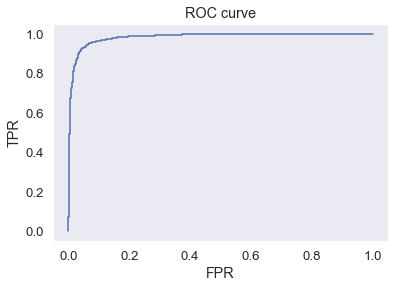

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


### Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      3604
           1       0.71      1.00      0.83      4215

    accuracy                           0.78      7819
   macro avg       0.85      0.76      0.76      7819
weighted avg       0.84      0.78      0.77      7819

Confusion Matrix:
[[1899 1705]
 [  11 4204]]
Accuracy(in percent):  78.05345952167796
AUC: 0.9801673506305766


Text(64.5, 0.5, 'Actual')

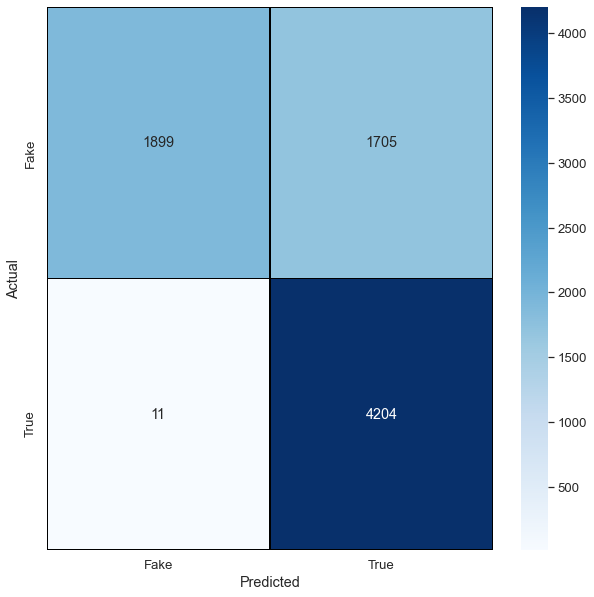

In [51]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
rf_tfidf=RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rf_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = rf_tfidf.predict(X_test_vectors_tfidf)
y_prob = rf_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print('Classification Report')
print(classification_report(y_test,y_predict))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_predict))
print('Accuracy(in percent): ',accuracy_score(y_test, y_predict)*100 )
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

rf = confusion_matrix(y_test, y_predict)
rf = pd.DataFrame(rf , index = ['Fake','True'] , columns = ['Fake','True'])
plt.figure(figsize = (10,10))
sea.heatmap(rf,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','True'] , yticklabels = ['Fake','True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")



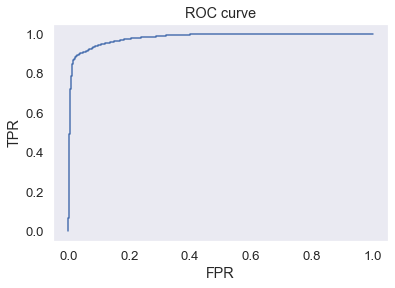

In [52]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


## Model Comparison

In [54]:
from sklearn.metrics import accuracy_score, log_loss

classifiers = [
          
          LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2'),
          MultinomialNB(),
          RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
         ]

log_cols=["Classifier"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_vectors_tfidf, y_train)
    name = clf.__class__.__name__
    y_predict = clf.predict(X_test_vectors_tfidf)
    y_prob = clf.predict_proba(X_test_vectors_tfidf)[:,1]
    print("="*30)
    print("\n")
    print(name)
    print('****Results****')
    print('Classification Report')
    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_predict))
    print('Accuracy(in percent): ',accuracy_score(y_test, y_predict)*100 )
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)
    ll = log_loss(y_test, y_predict)
    print("Log Loss: {}".format(ll))
    print("\n")




LogisticRegression
****Results****
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3604
           1       0.99      0.99      0.99      4215

    accuracy                           0.99      7819
   macro avg       0.99      0.99      0.99      7819
weighted avg       0.99      0.99      0.99      7819

Confusion Matrix:
[[3563   41]
 [  37 4178]]
Accuracy(in percent):  99.00242997825809
AUC: 0.9993756772164315
Log Loss: 0.34455267199100637




MultinomialNB
****Results****
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3604
           1       0.93      0.96      0.94      4215

    accuracy                           0.94      7819
   macro avg       0.94      0.94      0.94      7819
weighted avg       0.94      0.94      0.94      7819

Confusion Matrix:
[[3288  316]
 [ 171 4044]]
Accuracy(in percent):  93.77158204373961
AUC: 